In [1]:
# Import libraries
import sys

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr, plot_mask
from diffdrr.data import read

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# Get transforms
transform = get_transforms(contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data",
    collection="HCC-TACE-Seg",
    transform=transform,
    download_len=5,
    val_frac=0.2,
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Get datalists
train_dl = train_ds.datalist
val_dl = val_ds.datalist

# Check length of datasets, dataloaders and datalists
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))
print(len(train_dl), len(val_dl))

2024-04-28 11:30:57,647 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-04-28 11:30:57,647 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-04-28 11:30:57,647 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-04-28 11:30:58,130 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-04-28 11:30:58,130 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-04-28 11:30:58,130 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-04-28 11:30:58,430 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [3]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

print(image.shape, seg.shape)
print(image.dtype, seg.dtype)

torch.Size([1, 1, 512, 512, 63]) torch.Size([1, 1, 512, 512, 63])
torch.float32 torch.int32


In [4]:
labels = [0, 1, 2, 3, 4]

# structures = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]
# labels = subject.structures.query(f"group in {structures}")["id"].tolist()

# Read in CT volume and label map
subject = read(tensor=image[0], label_tensor=seg[0], labels=labels, orientation="AP", bone_attenuation_multiplier=5)

In [5]:
subject_path = read(
    filename=train_dl[0]["image"],
    orientation="AP",
    bone_attenuation_multiplier=5,
)

In [6]:
print(subject_path["volume"])
print(subject["volume"])

ScalarImage(shape: (1, 512, 512, 63); spacing: (0.70, 0.70, 2.50); orientation: RAS+; dtype: torch.IntTensor; memory: 63.0 MiB)
ScalarImage(shape: (1, 512, 512, 63); spacing: (0.70, 0.70, 2.50); orientation: RAS+; dtype: torch.FloatTensor; memory: 63.0 MiB)


In [7]:
print(subject["volume"].affine)
print(subject_path["volume"].affine)

[[   0.703125     0.           0.        -179.6484375]
 [   0.           0.703125     0.        -179.6484375]
 [   0.           0.           2.5        -77.5      ]
 [   0.           0.           0.           1.       ]]
[[   0.703125     0.           0.        -179.6484375]
 [   0.           0.703125     0.        -179.6484375]
 [   0.           0.           2.5        -77.5      ]
 [   0.           0.           0.           1.       ]]


In [8]:
# Create a DRR object
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample = None,  # Proportion of pixels to randomly subsample
    reshape = True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis = True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size = None,  # Render patches of the DRR in series
    renderer = "siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

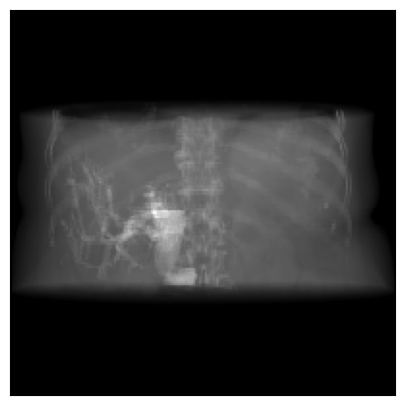

In [34]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)
pose = convert(
    rotations, translations, parameterization="euler_angles", convention="ZXY"
)
img = drr(pose, mask_to_channels = True)
im = img.sum(dim=1, keepdim=True)
plot_drr(im, ticks=False)
plt.show()

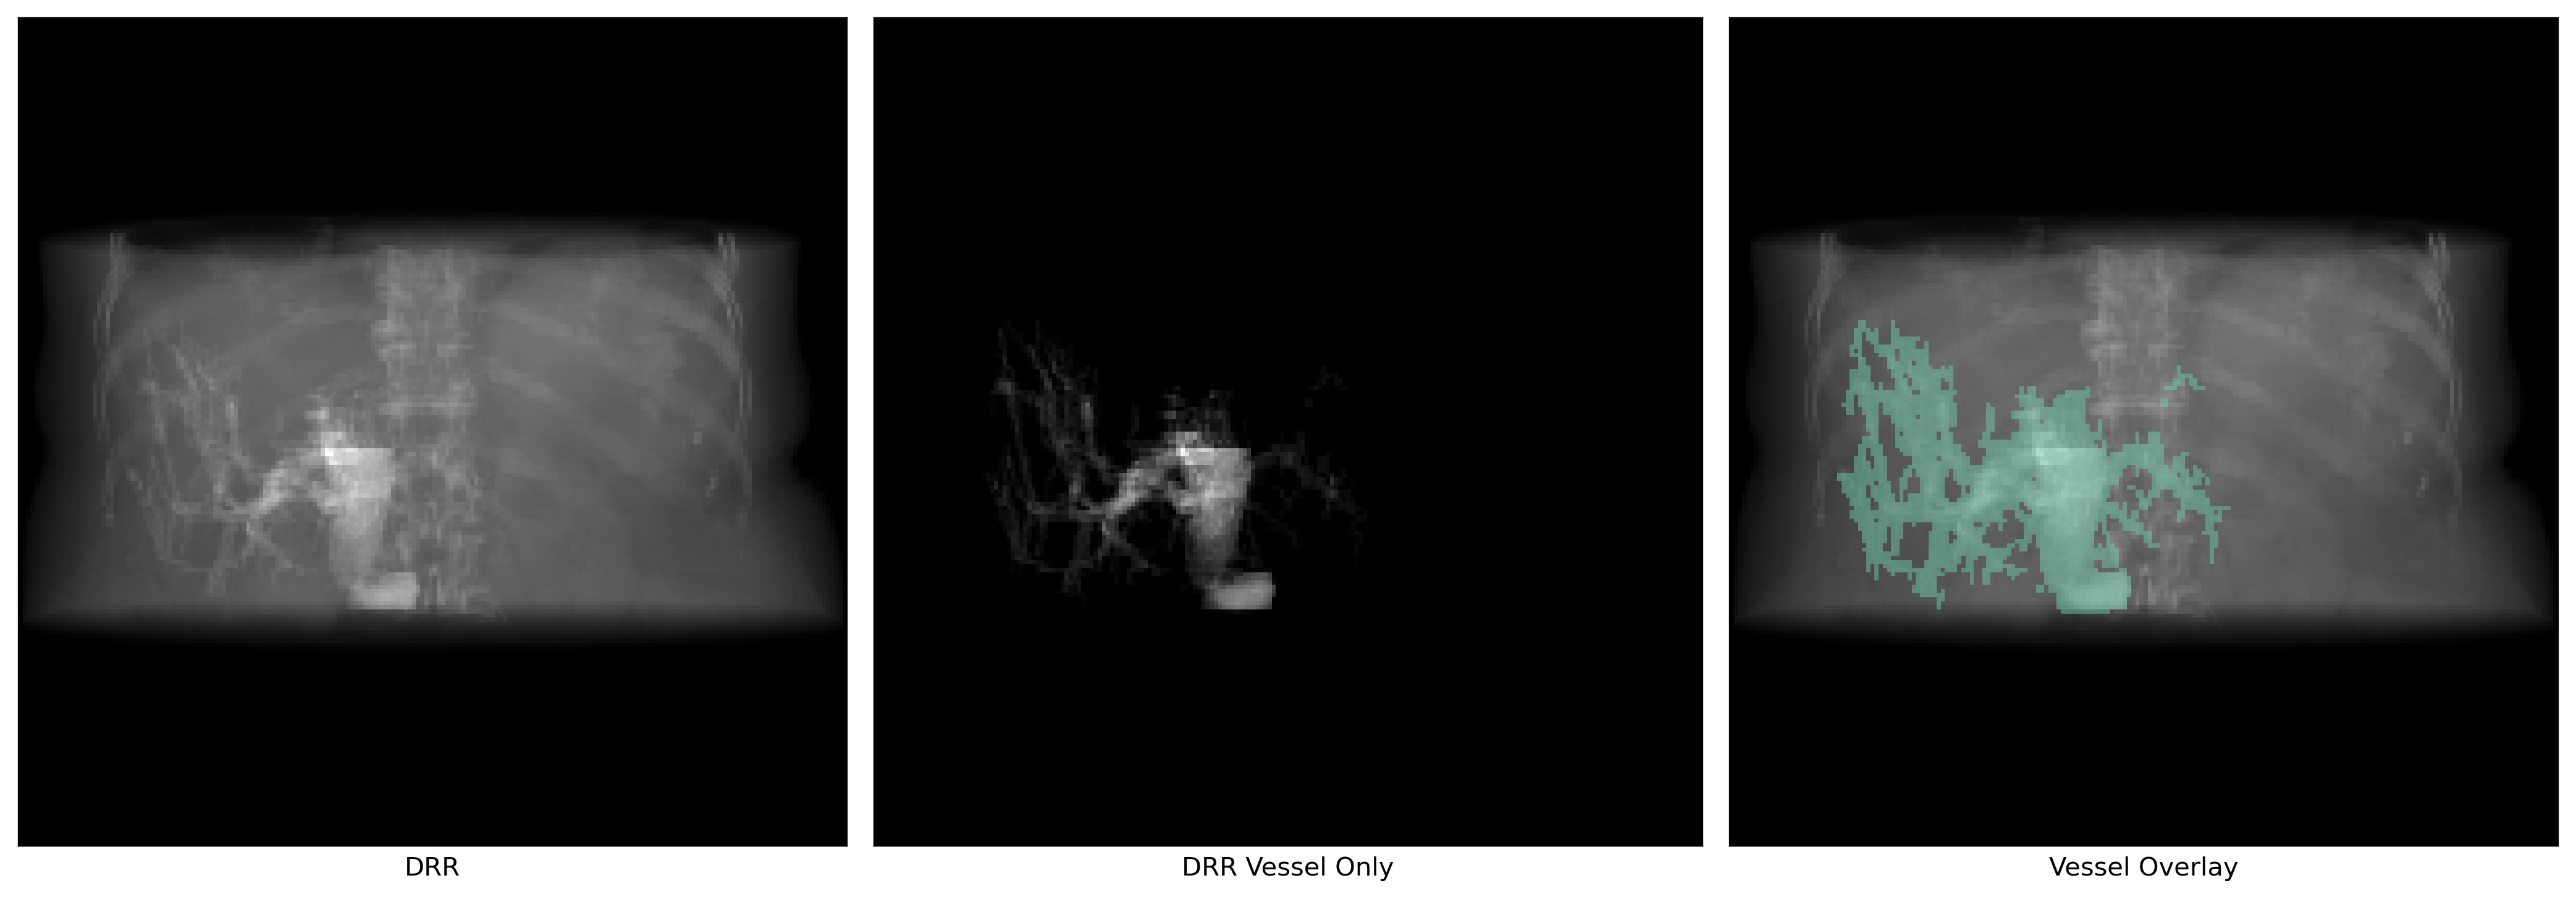

In [12]:
labels = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]

# Plot the segmentation masks
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(14, 7.75),
    tight_layout=True,
    dpi=300,
)

im = img.sum(dim=1, keepdim=True)
plot_drr(im, axs=axs[0], ticks=False, title="DRR")
plot_drr(img[:, 2, :, :].unsqueeze(dim=1), axs=axs[1], ticks=False, title="DRR Vessel Only")
plot_drr(im, axs=axs[2], ticks=False, title="Vessel Overlay")

for idx, label in enumerate(labels):
    if label == "Portal vein":
        mask = img[:, idx, :, :].unsqueeze(dim=1)
        plot_mask(mask, axs=axs[2], alpha=0.5)

In [ ]:
import matplotlib.pyplot as plt
import pyvista
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh, labelmap_to_mesh, plot_drr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Make a mesh from the CT volume
ct = drr_to_mesh(subject, "surface_nets", threshold=225, verbose=True)

In [ ]:
# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device)

# Make a pose
zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 800.0, 0.0]], device=device)
rot = torch.tensor([[torch.pi / 4, torch.pi / 6, 0.0]], device=device)
pose1 = convert(zero, xyz, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rot, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)

plot_drr(drr(pose))
plt.show()

In [ ]:
# Make a mesh from the camera and detector plane
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# Make the plot
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()

plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
# plotter.export_html("render.html")